In [1]:
import netCDF4
import numpy as np
import pandas as pd
import os
import xarray as xr
from fbprophet.utilities import regressor_coefficients
import pandas as pd
from fbprophet import Prophet
import seaborn as sns
import multiprocessing
import matplotlib
multiprocessing.set_start_method("fork")

In [2]:
matplotlib.__version__

'3.6.2'

# CERES

In [3]:
ceres_1 = pd.read_parquet("../CERES_2022-11-09_25176/ceres.parquet.gzip")
ceres_2 = pd.read_parquet("../CERES_2022-11-09_25176/ceres1.parquet.gzip")


In [4]:
ceres = pd.concat([ceres_2,ceres_1])

In [5]:
lat_lon_weight = pd.read_csv("zone_weights_lou.txt")

In [6]:
ceres = ceres.query('lat > -66 & lat <66')

In [7]:
weights = []
for index, group in ceres.groupby(level="lat"):
    weight = lat_lon_weight[lat_lon_weight["lat"] ==index]["weight"].iloc[0]
    weights.append(weight)

In [8]:
i=0 
for index, group in ceres.groupby(level="lat"):
    ceres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [9]:
TERMINATOR = True
ceres["albedo"] = ceres["toa_alb_all_mon"]*ceres["weights"]*(1/360.0)
data_agg_ceres = ceres.groupby(level="time").mean()
if TERMINATOR: 
    data_agg_ceres["albedo"]=(360*132/np.sum(weights))*data_agg_ceres["albedo"]
else:
    data_agg_ceres["albedo"]=(360*180)*data_agg_ceres["albedo"]

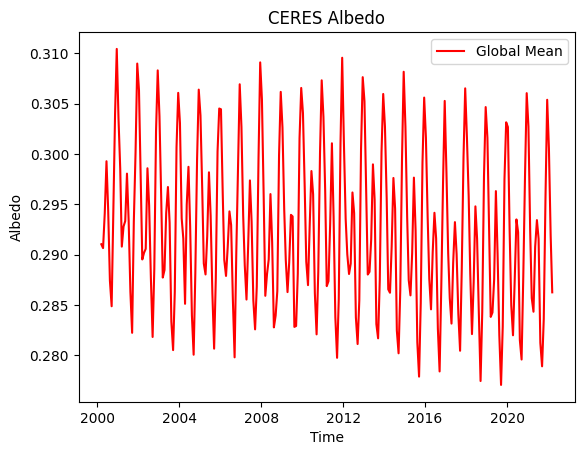

In [10]:
import matplotlib.pyplot as plt
sns.lineplot(data_agg_ceres["albedo"],label="Global Mean",c="red")
plt.ylabel("Albedo")
plt.xlabel("Time")
plt.title("CERES Albedo")
plt.savefig('plots/albedo.png')


### Basline Machine Learning Approach

In [11]:
ceres.reset_index(inplace=True)

In [12]:
to_drop_with_total = [col  for col in ceres.columns if "cld" in col or "lwp" in col or "iwp" in col]
to_drop_no_total = list(filter(lambda x:"total" not in x,to_drop_with_total))
# ceres.drop(to_drop,axis=1,inplace=True)
to_drop_no_total.extend(["weights",])

In [13]:
ceres.drop(to_drop_no_total,axis=1,inplace=True)

In [14]:
import datetime
ceres["month"]=ceres["time"].apply(lambda row: row.month)
ceres["year"]=ceres["time"].apply(lambda row: row.year)


In [15]:
ceres.drop(["albedo","time"],axis=1,inplace=True)

In [16]:
ceres.dropna(inplace=True)

In [17]:

# ceres_samp = ceres.sample(frac=0.05)


In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import shap
# Function to train an Extra Trees Classifier and compute SHAP feature importances
# def extra_trees_shap_importance(X, y, n_estimators=500, random_state=42):
    # Split the dataset into training and testing sets
# n_estimators=500
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the Extra Trees Classifier
# clf = ExtraTreesRegressor(n_estimators=n_estimators, 
#                           random_state=42,
#                           max_depth=8,verbose=2)
# #     clf = LinearRegression()
# # clf.fit(X_train, y_train)
# print("clf fit")

# shap_feature_importance,raw_shap_values = extra_trees_shap_importance(X,y) 

In [36]:
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingRegressor

X = ceres.loc[:, ceres.columns!='toa_alb_all_mon']
y = ceres.loc[:, ceres.columns=='toa_alb_all_mon']
X["northern_hemipshere"] = 1.0
X.loc[X['lat'] <= 0,
      "northern_hemipshere"] = 0.0
X.drop(["year"],
       axis=1,
       inplace=True)

In [21]:
X.columns

Index(['lon', 'lat', 'cldarea_total_mon', 'cldtau_total_mon',
       'cldtau_lin_total_mon', 'lwp_total_mon', 'iwp_total_mon',
       'cldwatrad_total_mon', 'cldicerad_total_mon', 'ini_precip_mon',
       'ini_albedo_mon', 'ini_aod55_mon', 'aux_snow_mon', 'month',
       'northern_hemipshere'],
      dtype='object')

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import clip_grad_value_

# Define the neural network mode
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, 
                                     hidden_size2,
                                     hidden_size3, 
                                     hidden_size4,
                         
                                     output_size,
                 dropout_rate):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)
        
#         self.dropout4 = nn.Dropout(dropout_rate)
        self.fc5 = nn.Linear(hidden_size4, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x


# Set the device to Apple GPU
# device = torch.device("metal:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
# Hyperparameters
input_size = len(X.columns)  # Number of input features
hidden_size1 = 128  # Number of hidden units in the first hidden layer
hidden_size2 = 64  # Number of hidden units in the second hidden layer
hidden_size3 = 32
hidden_size4 = 16# Number of hidden units in the second hidden layer

output_size = 1  # Number of output features (for regression it is 1)
batch_size = 8
learning_rate = 0.001
num_epochs = 4
dropout = 0.0

# # Create sample data




# Split the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), 
                                                    y.to_numpy().astype(np.float32), 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_vals, X_test_vals =  X_train.values.copy(), X_test.values.copy()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)


# print(X_train.values)
# # Create data loaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_test),
                            torch.tensor(y_test))
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size,
                        shuffle=False)

# # # Initialize the model, loss function, and optimizer
model = FeedForwardNN(input_size, 
                      hidden_size1, 
                      hidden_size2,
                      hidden_size3,
                      hidden_size4,
                      output_size,
                      dropout).to(device)
PATH = "albedo_ffnn_5layer_relu_v0_66_terminator_epoch_0_valloss_0.011515176099699246.pth"

model_weights = torch.load(PATH)
model.load_state_dict(model_weights.state_dict())
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=1, 
                                      gamma=0.5)

# # # Training loop
for epoch in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as progress_bar:
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
#             print(data)
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

#             Backward pass
            optimizer.zero_grad()
            loss.backward()
#             clip_grad_value_(model.parameters(), clip_value=.99)
            optimizer.step()

            # Update the progress bar
            progress_bar.set_postfix({'loss': loss.item()})
            progress_bar.update()

    # Update the learning rate
    scheduler.step()

    # Evaluation on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)
    PATH = f"albedo_ffnn_5layer_relu_v0_66_terminator_epoch_{epoch}_valloss_{val_loss}.pth"
    torch.save(model,PATH)


    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1259276/1259276 [12:35:48<00:00, 27.77it/s, loss=0.00315]


Epoch [1/4], Loss: 0.0031, Val Loss: 0.0012


Epoch 2/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1259276/1259276 [5:29:54<00:00, 63.62it/s, loss=0.000909]


Epoch [2/4], Loss: 0.0009, Val Loss: 0.0013


Epoch 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1259276/1259276 [5:40:33<00:00, 61.63it/s, loss=0.0138]


Epoch [3/4], Loss: 0.0138, Val Loss: 0.0011


Epoch 4/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1259276/1259276 [13:22:04<00:00, 26.17it/s, loss=0.00547]


Epoch [4/4], Loss: 0.0055, Val Loss: 0.0014


In [33]:
model_weights = torch.load(PATH)
model_weights.state_dict()

/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


OrderedDict([('fc1.weight',
              tensor([[ 0.0162, -0.0269,  0.8919,  ..., -0.2611,  0.0048,  0.0451],
                      [ 0.0094,  0.0883, -0.0947,  ...,  0.0133,  0.0871, -0.0476],
                      [ 0.0083, -0.0445, -0.2767,  ..., -0.3208, -0.0154,  0.0474],
                      ...,
                      [ 0.0034, -0.0108, -0.0177,  ...,  0.0371,  0.0031,  0.0036],
                      [ 0.0073, -0.0301,  0.2221,  ..., -0.0060, -0.0013,  0.0084],
                      [-0.0205, -0.1328,  0.0246,  ...,  0.0274,  0.4849, -0.0411]],
                     device='mps:0')),
             ('fc1.bias',
              tensor([-2.1554e-01, -1.4861e-02, -1.3026e-01,  2.3636e-01,  1.1263e-01,
                       3.3014e-02,  2.9869e-02,  7.6029e-02, -1.6646e-02,  1.4009e-01,
                      -1.2965e-01, -1.3162e-04, -5.0357e-02,  5.5709e-02,  1.9877e-01,
                      -7.1436e-02, -1.8877e-01,  5.5493e-02, -2.3735e-01,  8.9173e-02,
                      -2.07

In [ ]:
X_train.max()


In [31]:
# PATH = "albedo_ffnn_5layer_relu_v0_66_terminator.pth"
# # model = torch.jit.load(PATH)
# # torch.save(model,PATH)
# model = torch.load(PATH)
!ls

Additive Impacts & Kernel Time Varying Regression.ipynb
Albedo Machine Learning with no TS model.ipynb
Albedo Neural Network .ipynb
Cleaned Up EDA.ipynb
Exploratory Data Analysis.ipynb
Kernel Time Varying Regression.ipynb
README.md
Untitled.ipynb
albedo_ffnn_4layer_relu_v0.pth
albedo_ffnn_5layer_relu_v0.pth
albedo_ffnn_5layer_relu_v0_66_terminator_epoch_0_valloss_0.011515176099699246.pth
albedo_ffnn_5layer_relu_v0_66_terminator_epoch_0_valloss_0.028589308267032057.pth
albedo_ffnn_5layer_relu_v0_66_terminator_epoch_1_valloss_0.02867528024880347.pth
albedo_ffnn_5layer_relu_v0_66_terminator_epoch_2_valloss_0.021511223232065883.pth
albedo_ffnn_5layer_relu_v0_66_terminator_epoch_3_valloss_0.026251066288401965.pth
albedo_ffnn_tanh_v0.pth
albedo_ffnn_v0.pth
ceres_calculated_mean_albedo_.png
ceres_global_means_albedo.png
plots
saved_models
zone_weights_lou.txt


In [17]:
PATH = "albedo_ffnn_v0.pth"
# torch.save(model, "albedo_ffnn_v0.pth")
model = torch.load(PATH)


NameError: name 'torch' is not defined

In [ ]:
!head -n 5 albedo_ffnn_4layer_relu_v0.pth

In [ ]:
columns = X.columns
for i in range(0,len(columns)):
    print(columns[i],i)

In [24]:
steps = np.arange(-.2,.2,.01)
# torch.mean(model(torch.tensor(X_test[0:50000]).to("mps")))

In [ ]:
scaler.inverse_transform(X_test.copy()).max()

In [25]:
feature_idx = 11
hemipshere_flag = 14
northern_peturbations = []
for step in steps:
    print(step)
    perturbation_frame = scaler.inverse_transform(X_test.copy())
    southern_hemisphere = np.where(perturbation_frame[:,hemipshere_flag] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,hemipshere_flag] == 1)
    np.add.at(perturbation_frame[:,feature_idx], northern_hemisphere, step)
#     print(perturbation_frame)
    perturbation_frame = scaler.transform(perturbation_frame)

    
    northern_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000]).to(device)).mean().item(),
                                 "step":step})


-0.2
-0.19
-0.18
-0.16999999999999998
-0.15999999999999998
-0.14999999999999997
-0.13999999999999996
-0.12999999999999995
-0.11999999999999994
-0.10999999999999993
-0.09999999999999992
-0.08999999999999991
-0.0799999999999999
-0.0699999999999999
-0.05999999999999989
-0.04999999999999988
-0.03999999999999987
-0.02999999999999986
-0.01999999999999985
-0.009999999999999842
1.6653345369377348e-16
0.010000000000000175
0.020000000000000184
0.030000000000000193
0.0400000000000002
0.05000000000000021
0.06000000000000022
0.07000000000000023
0.08000000000000024
0.09000000000000025
0.10000000000000026
0.11000000000000026
0.12000000000000027
0.13000000000000028
0.1400000000000003
0.1500000000000003
0.1600000000000003
0.17000000000000032
0.18000000000000033
0.19000000000000034


In [26]:
southern_hemisphere

(array([      3,       4,       5, ..., 2518539, 2518541, 2518547]),)

In [27]:
# feature_idx = 9
southern_peturbations = []
for step in steps:
    perturbation_frame = scaler.inverse_transform(X_test.copy())
    southern_hemisphere = np.where(perturbation_frame[:,hemipshere_flag] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,hemipshere_flag] == 1)
    np.add.at(perturbation_frame[:,feature_idx], southern_hemisphere, step)
    print("MEAN:",np.mean(perturbation_frame[:,feature_idx]),
          " MAX:",np.max(perturbation_frame[:,feature_idx]),
          " STEP:", step)
    perturbation_frame = scaler.transform(perturbation_frame)
    southern_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000,:]).to(device)).mean().item(),
                                 "step":step})


MEAN: 0.06408251  MAX: 2.256923  STEP: -0.2
MEAN: 0.06907787  MAX: 2.256923  STEP: -0.19
MEAN: 0.07407319  MAX: 2.256923  STEP: -0.18
MEAN: 0.07906852  MAX: 2.256923  STEP: -0.16999999999999998
MEAN: 0.084063835  MAX: 2.256923  STEP: -0.15999999999999998
MEAN: 0.08905918  MAX: 2.256923  STEP: -0.14999999999999997
MEAN: 0.09405444  MAX: 2.256923  STEP: -0.13999999999999996
MEAN: 0.099049814  MAX: 2.256923  STEP: -0.12999999999999995
MEAN: 0.10404514  MAX: 2.256923  STEP: -0.11999999999999994
MEAN: 0.109040454  MAX: 2.256923  STEP: -0.10999999999999993
MEAN: 0.114035785  MAX: 2.256923  STEP: -0.09999999999999992
MEAN: 0.1190311  MAX: 2.256923  STEP: -0.08999999999999991
MEAN: 0.12402641  MAX: 2.256923  STEP: -0.0799999999999999
MEAN: 0.12902176  MAX: 2.256923  STEP: -0.0699999999999999
MEAN: 0.1340171  MAX: 2.256923  STEP: -0.05999999999999989
MEAN: 0.13901249  MAX: 2.256923  STEP: -0.04999999999999988
MEAN: 0.14400768  MAX: 2.256923  STEP: -0.03999999999999987
MEAN: 0.14900312  MAX: 2.2

In [28]:
# feature_idx = 9
global_peturbations = []
for step in steps:
#     print(step)
    perturbation_frame = scaler.inverse_transform(X_test.copy())
    southern_hemisphere = np.where(perturbation_frame[:,hemipshere_flag] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,hemipshere_flag] == 1)
    np.add.at(perturbation_frame[:,feature_idx], southern_hemisphere, step)
    np.add.at(perturbation_frame[:,feature_idx], northern_hemisphere, step)
    print("MEAN:",np.mean(perturbation_frame[:,feature_idx]),
          " MAX:",np.max(perturbation_frame[:,feature_idx]),
          " STEP:", step)
    perturbation_frame = scaler.transform(perturbation_frame)
#     perturbation_frame = scaler.transform(perturbation_frame).astype(np.float32)
    global_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000,:]).to(device)).mean().item(),
                                 "step":step})


MEAN: -0.036010973  MAX: 2.056923  STEP: -0.2
MEAN: -0.026010966  MAX: 2.066923  STEP: -0.19
MEAN: -0.01601097  MAX: 2.076923  STEP: -0.18
MEAN: -0.006010972  MAX: 2.086923  STEP: -0.16999999999999998
MEAN: 0.0039890334  MAX: 2.0969229  STEP: -0.15999999999999998
MEAN: 0.013989026  MAX: 2.1069229  STEP: -0.14999999999999997
MEAN: 0.023989031  MAX: 2.1169229  STEP: -0.13999999999999996
MEAN: 0.03398904  MAX: 2.126923  STEP: -0.12999999999999995
MEAN: 0.043989025  MAX: 2.136923  STEP: -0.11999999999999994
MEAN: 0.05398905  MAX: 2.146923  STEP: -0.10999999999999993
MEAN: 0.063989036  MAX: 2.156923  STEP: -0.09999999999999992
MEAN: 0.073989056  MAX: 2.166923  STEP: -0.08999999999999991
MEAN: 0.08398905  MAX: 2.176923  STEP: -0.0799999999999999
MEAN: 0.09398903  MAX: 2.186923  STEP: -0.0699999999999999
MEAN: 0.10398899  MAX: 2.196923  STEP: -0.05999999999999989
MEAN: 0.113989  MAX: 2.206923  STEP: -0.04999999999999988
MEAN: 0.12398909  MAX: 2.216923  STEP: -0.03999999999999987
MEAN: 0.13398

NameError: name 'columns' is not defined

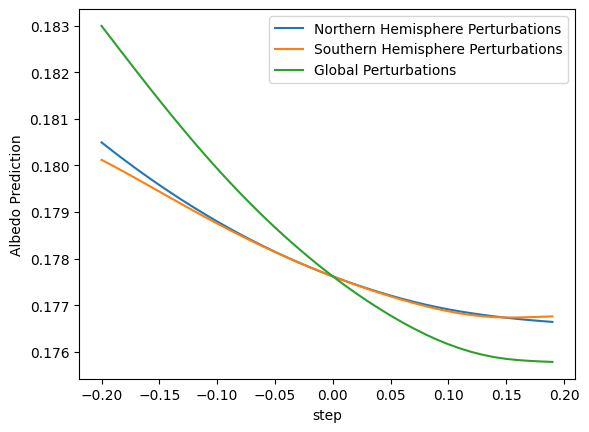

In [29]:
northern_peturb_df = pd.DataFrame(northern_peturbations)
southern_peturb_df = pd.DataFrame(southern_peturbations)
global_peturb_df = pd.DataFrame(global_peturbations)
combo = northern_peturb_df.copy()
# combo["prediction"] = (northern_peturb_df["prediction"]+southern_peturb_df["prediction"])/2

sns.lineplot(y="prediction",x="step",data=northern_peturb_df,label="Northern Hemisphere Perturbations")
sns.lineplot(y="prediction",x="step",data=southern_peturb_df,label="Southern Hemisphere Perturbations")
sns.lineplot(y="prediction",x="step",data=global_peturb_df,label="Global Perturbations")
# sns.lineplot(y="prediction",x="step",data=combo,label="Mean Combines Hemispheric Peturbation")


plt.ylabel("Albedo Prediction")
plt.xlabel(f"{columns[feature_idx]} Step")


In [ ]:
feature_idx = 9
southern_peturbations = []
for step in steps:
    perturbation_frame = X_test.values.copy()
    southern_hemisphere = np.where(perturbation_frame[:,13] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,13] == 1)
    np.add.at(perturbation_frame[:,feature_idx], southern_hemisphere, step)
#     perturbation_frame = scaler.transform(perturbation_frame).astype(np.float32)
    southern_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000,:]).to(device)).mean().item(),
                                 "step":step})
northern_peturbations = []
for step in steps:
    print(step)
    perturbation_frame = X_test.copy()
    southern_hemisphere = np.where(perturbation_frame[:,13] < 1)
    northern_hemisphere = np.where(perturbation_frame[:,13] == 1)
    np.add.at(perturbation_frame[:,feature_idx], northern_hemisphere, step)
    northern_peturbations.append({"prediction":model(torch.tensor(perturbation_frame[0:50000,:]).to(device)).mean().item(),
                                 "step":step})


In [ ]:
northern_peturb_df = pd.DataFrame(northern_peturbations)
southern_peturb_df = pd.DataFrame(southern_peturbations)

sns.scatterplot(y="prediction",x="step",data=northern_peturb_df,label="Northern Hemisphere Perturbations")
sns.scatterplot(y="prediction",x="step",data=southern_peturb_df,label="Southern Hemisphere Perturbations")
plt.ylabel("Albedo Prediction")
plt.xlabel("Surface Albedo Step")

In [ ]:
perturbation_frame.shape[0]

In [ ]:
scaler.get_feature_names_out()

In [ ]:
from sklearn import metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
regression_results(prediction,y_test)

In [ ]:
perturbation_frame = X_test.copy()
# southern_hemisphere = perturbation_frame.loc[X_test['lat'] < 0] 
# northerm_hemisphere = perturbation_frame.loc[X_test['lat'] >= 0] 
# perturbation_frame.loc[southern_hemisphere.index,"ini_aod55_mon"]+=1000

In [ ]:
scaler.transform(perturbation_frame)

In [ ]:
# perturbation_frame['ini_aod55_mon'] +=.1
perturbed_prediction = clf.predict(perturbation_frame)


In [ ]:
sns.histplot(prediction,alpha=0.3) 
sns.histplot(perturbed_prediction,alpha=0.3) 
print(prediction.mean(),perturbed_prediction.mean())

In [ ]:
perturbation_frame['ini_aod55_mon']

In [ ]:
import xgboost
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# Initialize the SHAP explainer with the model
explainer = shap.Explainer(clf)

# Compute SHAP interaction values for a subset of test instances
shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:1000, :])

# Plot the SHAP interaction values for a specific instance (e.g., the first instance)
shap_interaction_matrix = pd.DataFrame(shap_interaction_values[0], columns=X.columns, index=X.columns)
shap.summary_plot(shap_interaction_values, X_test.iloc[:1000, :])

In [ ]:
shap_values = explainer(X_test)
# shap_values

cld_area_total_mon, ini_albedo_mon, ini_aod55_mon interact with each other and lat, lon, year, month


In [ ]:
columns = X_test.columns
print(columns)

In [ ]:
shap.dependence_plot("cldarea_total_mon", 
                     shap_values.values, 
                     X_test,interaction_index=1)

In [ ]:
 shap_values[:, interaction_idx].values

In [ ]:
shap_values[:, 1]

In [ ]:
# Create a SHAP dependence plot with marginal histogram
index_dict = {}
for i in range(len(columns)):
    index_dict[columns[i]] = i
# feature_idx = 2
# interaction_idx = 10
# shap.plots.scatter(shap_values[:, feature_idx], 
#                    color=shap_values[:, interaction_idx], 
#                     dot_size=0.5,
#                       alpha = 0.5)

# # plt.title("SHAP Dependence Plot")

In [ ]:
index_dict
'cld_area_total_mon'

In [ ]:
interaction_terms = []

variables_1 = ["cldarea_total_mon", "ini_albedo_mon", "ini_aod55_mon"]
variables_2 = ["lat", "lon", "year", "month"]

for i, var1 in enumerate(variables_1):
    for var2 in variables_1[i+1:] + variables_2:
        if var1 != var2:  # To avoid interaction of a variable with itself
            interaction_term = [var1, var2]
            interaction_terms.append(interaction_term)

print(len(interaction_terms))

In [ ]:
import scipy

In [ ]:
# # Create a SHAP dependence plot with marginal histogram
# print(columns)
# feature_idx = 2
# interaction_idx = 11
# shap.plots.scatter(shap_values[:, feature_idx], 
#                    color=shap_values[:, interaction_idx], 
#                     dot_size=0.5,
#                   alpha = 0.5)

# plt.title("SHAP Dependence Plot")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
def scatter_plot_matrix(data, interaction_terms, index_dict):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
    
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            interaction_term = interaction_terms[i*3 + j]
            x_var, y_var = interaction_term
            x_index, y_index = index_dict[x_var], index_dict[y_var]
            
            im = ax.scatter(data[:, x_index].values, 
                       data[:, y_index].values, 
                       alpha=1,
                       s=1,
                       c = y_test["toa_alb_all_mon"].tolist(),
                        cmap = "coolwarm")
            r, p = scipy.stats.pearsonr(data[:, x_index].values, data[:, y_index].values)
            r=round(r,3)
            ax.set_title(f"Pearson R = {r}")
            plt.colorbar(im, ax=ax)
            ax.set_xlabel(x_var)
            ax.set_ylabel(y_var)
    
    # Remove empty plots if the number of interaction terms is not exactly 15
    for k in range(len(interaction_terms), 15):
        i, j = k // 3, k % 3
        axes[i, j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:

# Create some random data
np.random.seed(42)
data = np.random.rand(100, 8)

# Define the index dictionary


# Call the function with the data, interaction terms, and index dictionary
scatter_plot_matrix(shap_values, interaction_terms, index_dict)
feature_idx = 2
interaction_idx = 11

# fig = plt.scatter(shap_values[:, 10].values,
#                   shap_values[:, 11].values,
#                   c = y_test["toa_alb_all_mon"].tolist(),
#                   cmap = "coolwarm",
#                   s = 1)
# plt.colorbar(fig)
#clouds vs latitude
# cloud vs year
# cloud vs 

In [ ]:
print(columns)
feature_idx = 2
interaction_idx = 11
shap.plots.scatter(shap_values[:, feature_idx], 
                   color=shap_values[:, interaction_idx], 
                    dot_size=0.5,
                  alpha = 0.5)

plt.title("SHAP Dependence Plot")


In [ ]:
X_test.reset_index(inplace=True,drop=True)

In [ ]:
# Hemespheric Albedo Shap Value comparison 
# Add stepped line plot for aerage shap vs. lat

X_test["cldarea_total_shap"] = shap_values.values[:,2]

In [ ]:
north = X_test[X_test["lat"]>0]
south = X_test[X_test["lat"]<0]

In [ ]:
south

In [ ]:
aggregated_data = X_test.groupby("lat").agg("median")

In [ ]:
for i in range(len(columns)):
    print(i,columns[i])

In [ ]:
 shap_values.values[:,2][south.index]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))
x = "lat"
y = "cldarea_total_mon"
# import cmap2
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test[x].min(),X_test[x].max()],[-1,1]]
feature_idx = 2
interaction_idx = 1

counts,_ ,_ = np.histogram2d(X_test[x],
                             shap_values[:, feature_idx].values,
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test[x],
                                     shap_values[:, feature_idx].values,
                                        bins=66,
                                        weights=X_test[y])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T)
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal",cmap="coolwarm")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"Cloud Area Fraction",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
#     lbl.set_fontproperties(helvetica)

ax.set_ylim(-0.15,0.15)
ax.set_ylabel(
    r"Cloud Area Fraction Shap Value",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"Latitude",
    fontproperties=helvetica,
)
# ax.hlines( shap_values.values[:,2].mean(),-70,70,label="Average Shap",color="blue")
ax.hlines( shap_values.values[south.index][:,2].mean(),-70,70,label="Average Shap (Southern)",color="red")
ax.hlines( shap_values.values[north.index][:,2].mean(),-70,70,label="Average Shap (Northern)",color="green")
ax.legend(fontsize=10)


vals, _, patches = ax_marginal.hist(
    shap_values[:, feature_idx].values, 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
#     color=cmap.mpl_colors[-2],
    alpha = 1)
aggregated_data = X_test.groupby("lat").agg("median")

# sns.lineplot(x="lat",
#              y="cldarea_total_shap",
#              data=aggregated_data,
#              ax=ax,
#             color="black")

ax_marginal.tick_params("both", direction="in")
# ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels() + ax_marginal.get_xticklabels() + ax_marginal.get_yticklabels():
#     lbl.set_fontproperties(helvetica)
# max_height = 0 
# for patch in patches:
#     height = patch.get_width()
#     if height>max_height:
#         max_height = height
# for patch in patches:
#     if  patch.get_width() == max_height:
# #         patch.set_color("blue")
#         patch.set_alpha(1)
#     else:
#         patch.set_alpha(.5)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))
x = "lat"
y = "ini_aod55_mon"
# import cmap2
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test[x].min(),X_test[x].max()],[-1,1]]
feature_idx = 11
interaction_idx = 1

counts,_ ,_ = np.histogram2d(X_test[x],
                             shap_values[:, feature_idx].values,
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test[x],
                                     shap_values[:, feature_idx].values,
                                        bins=66,
                                        weights=X_test[y])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T)
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"AOD",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
#     lbl.set_fontproperties(helvetica)

# ax.set_ylim(-0.15,0.15)
ax.set_ylabel(
    r"AOD Shap Value",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"Latitude",
    fontproperties=helvetica,
)
ax.hlines( shap_values.values[:,feature_idx].mean(),-70,70,label="Average Shap",color="blue")
ax.hlines( shap_values.values[south.index][:feature_idx].mean(),-70,70,label="Average Shap (Southern)",color="red")
ax.hlines( shap_values.values[north.index][:,feature_idx].mean(),-70,70,label="Average Shap (Northern)",color="green")
ax.legend(fontsize=10)


vals, _, patches = ax_marginal.hist(
    shap_values[:, feature_idx].values, 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
#     color=cmap.mpl_colors[-2],
    alpha = 1)
aggregated_data = X_test.groupby("lat").agg("median")
# sns.lineplot(x="lat",
#              y=y,
#              data=aggregated_data,
#              ax=ax,
#             color="black")

ax_marginal.tick_params("both", direction="in")
# ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))
x = "lat"
y = "ini_albedo_mon"
# import cmap2
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test[x].min(),X_test[x].max()],[-1,1]]
feature_idx = 10
interaction_idx = 1

counts,_ ,_ = np.histogram2d(X_test[x],
                             shap_values[:, feature_idx].values,
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test[x],
                                     shap_values[:, feature_idx].values,
                                        bins=66,
                                        weights=X_test[y])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T)
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"Surface Albedo",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

# for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
#     lbl.set_fontproperties(helvetica)

# ax.set_ylim(-0.15,0.15)
ax.set_ylabel(
    r"Surface Albedo Shap Value",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"Latitude",
    fontproperties=helvetica,
)
ax.hlines( shap_values.values[:,feature_idx].mean(),-70,70,label="Average Shap",color="blue")
ax.hlines( shap_values.values[south.index][:feature_idx].mean(),-70,70,label="Average Shap (Southern)",color="red")
ax.hlines( shap_values.values[north.index][:,feature_idx].mean(),-70,70,label="Average Shap (Northern)",color="green")
ax.legend(fontsize=10,loc="upper left")


vals, _, patches = ax_marginal.hist(
    shap_values[:, feature_idx].values, 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
#     color=cmap.mpl_colors[-2],
    alpha = 1)
aggregated_data = X_test.groupby("lat").agg("median")
# sns.lineplot(x="lat",
#              y=y,
#              data=aggregated_data,
#              ax=ax,
#             color="black")

ax_marginal.tick_params("both", direction="in")
# ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

In [ ]:
aggregated_data

In [ ]:
# shap.dependence_plot("cldtau_total_mon", 
#                      shap_values,
#                      X_test,
#                      interaction_index="month")
shap.dependence_plot("cldarea_total_mon", 
                     shap_values, 
                     X_test, 
                     interaction_index="lat")


In [ ]:
sns.scatterplot(x=shap_values.values[:,5],
                y=shap_values.values[:,10])

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:1000, :])

shap.summary_plot(shap_interaction_values, X_test.iloc[:1000,:])


In [ ]:
# shap.dependence_plot("cldtau_total_mon", 
#                      shap_values, X_test)
shap.dependence_plot("cldtau_total_mon", 
                     shap_values.base_values[0],
                     X_test,
                     interaction_index="month")


In [ ]:
hap.waterfall_plot(explainer.base_values[0], values[0], X[0])

In [ ]:
X_test["performance"] = 100*(X_test["y"]-X_test["predictions"])/X_test["y"]


In [ ]:
X_test.columns

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.cmocean.sequential import Dense_7 as cmap
from palettable.cartocolors.sequential import Purp_7 as cmap
from palettable.cartocolors.sequential import Peach_7 as cmap2
import matplotlib as mpl
import matplotlib.font_manager as fm
from pathlib import Path

plt.rcParams['axes.unicode_minus'] = False
plt.rc('text', usetex=False)
helvetica =  fm.FontProperties(fname=Path("/Users/samuelkahn/Desktop/Astronomy/Brants Group/hsc-hst-super-resolution-paper/helvetica.ttf"))

f, (ax, ax_marginal) = plt.subplots(figsize=(5, 5), ncols=2, dpi=600, sharey=True)



hist = ax.hist2d(
    X_test["lat"],
    X_test["performance"],
    cmap=cmap2.get_mpl_colormap(), 
    weights=X_test["cldarea_total_mon"],
    norm=mpl.colors.LogNorm(),
    bins=66,
#     range=[[limit, upper], [-1, 1]]
)
# ax.plot([limit, upper], [0, 0],  "-", alpha=0.5,  color=line_color)

ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
print(hist[-1])
cbar = plt.colorbar(hist[-1], cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"$R_e$",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
    lbl.set_fontproperties(helvetica)

ax.set_ylim(-150,150)

ax.set_ylabel(
    r"$\cdot\frac{y-\hat{y}}{y}\cdot 100$",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"$lat$",
    fontproperties=helvetica,
)


vals, _, patches = ax_marginal.hist(
    X_test["performance"], 
    bins=66, 
    log=True,
#     range=[-1, 1], 
    orientation="horizontal",
    color=cmap.mpl_colors[-2]
)


In [ ]:
f, (ax, ax_marginal) = plt.subplots(figsize=(10, 5), ncols=2, dpi=600, sharey=True)

range_lims = [[X_test["lat"].min(),X_test["lat"].max()],[-150,150]]

counts,_ ,_ = np.histogram2d(X_test["lat"],
                             X_test["performance"],
                             bins=66)
sums,x_edges ,y_edges = np.histogram2d(X_test["lat"],
                                    X_test["performance"],
                                       bins=66,
                                       weights=X_test["cldarea_total_mon"])

hist = ax.pcolormesh(x_edges ,y_edges,(sums/counts).T,   
               cmap=cmap2.get_mpl_colormap())
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlim(x_edges[0],x_edges[-1])


ax.tick_params("both", direction="in")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(hist, cax = cax1, orientation="horizontal")
cbar.ax.tick_params("both", which="both", direction="in")


cbar.ax.set_xlabel(
    r"$A_{cld}$",
    fontproperties=helvetica,
)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("top")

for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels():
    lbl.set_fontproperties(helvetica)

ax.set_ylim(-150,150)

ax.set_ylabel(
    r"$\cdot\frac{y-\hat{y}}{y}\cdot 100$",
    fontproperties=helvetica,
)
ax.set_xlabel(
    r"$lat$",
    fontproperties=helvetica,
)

vals, _, patches = ax_marginal.hist(
    X_test["performance"], 
    bins=66, 
#     log=True,
#     range=[-5, 5], 
    orientation="horizontal",
    color=cmap.mpl_colors[-2],
    alpha = 0.0)
ax_marginal.tick_params("both", direction="in")
ax_marginal.set_xlabel(r"$N$", fontproperties=helvetica)
ax_marginal.set_xlim(0, vals.max())
ax_marginal.set_xticks([500, 1000])
ax_marginal.spines.right.set_visible(False)
ax_marginal.spines.top.set_visible(False)

for lbl in ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_xticklabels() + ax_marginal.get_xticklabels() + ax_marginal.get_yticklabels():
    lbl.set_fontproperties(helvetica)
max_height = 0 
for patch in patches:
    height = patch.get_width()
    if height>max_height:
        max_height = height
for patch in patches:
    if  patch.get_width() == max_height:
#         patch.set_color("blue")
        patch.set_alpha(1)
    else:
        patch.set_alpha(.5)


divider = make_axes_locatable(ax_marginal)
hide = divider.append_axes("top", size="5%", pad=0.05)
hide.set_visible(False)

plt.subplots_adjust(wspace=0.05)

In [ ]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
X_test["cldarea_total_mon"].max()